#### Based on [`"Using GAN for Generating Hand-written Digit Images" by Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/gan_mnist.ipynb)

## ✒️ Styling, Libraries, and Helpful Functions

In [1]:
%%html
<style>        
h2,h3 {text-shadow:4px 4px 4px #aaa;} 
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:#39d4be;}; div.input_prompt {color:#37c9e1;} 
div.output_area pre,div.output_subarea {color:#39d4be;}
div.output_stderr pre {background-color:ghostwhite;}
</style>

In [2]:
import warnings; warnings.filterwarnings("ignore")
import h5py,cv2,os
import pandas as pd,numpy as np,pylab as pl
import keras as ks,tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,Nadam
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
np.set_printoptions(precision=8); rn=np.random.randint(5000)
from keras import __version__
print('keras version:',__version__)
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0-rc1


In [3]:
def preprocess(x):    
    x=(x-.5)*2
    return np.clip(x,-1,1)
def deprocess(x):
    x=(x/2+.5)*255
#    np.place(x,x>220,255)
    x=np.clip(x,0,255)
    x=np.uint8(x)
    return x.reshape(28,28)
def latent_samples(n_samples,sample_size):
    return np.random.normal(loc=0,scale=1,
                            size=(n_samples,sample_size))
latent_sample784=latent_samples(1,784)
def display_images(generated_images):
    n_images=len(generated_images)
    rows=4; cols=n_images//rows    
    pl.figure(figsize=(cols,rows))
    for i in range(n_images):
        img=deprocess(generated_images[i])
        pl.subplot(rows,cols,i+1)
        pl.imshow(img,cmap=pl.cm.bone)
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()

## ✒️ Loading & Preprocessing the Data

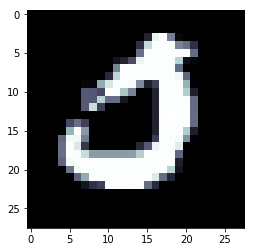

(42000, 784)

In [4]:
df_train=pd.read_csv("../input/train.csv")
id_images=["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
train_images=np.array(df_train[id_images])
train_images=train_images.astype('float32').reshape(-1,784)
pl.imshow(np.squeeze(train_images[rn].reshape(28,28)),
          cmap=pl.cm.bone);pl.show()
train_images.shape

In [5]:
df_test=pd.read_csv("../input/test.csv")
id_images=["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
test_images=np.array(df_test[id_images])
test_images=test_images.astype('float32').reshape(-1,784)
test_images.shape

(28000, 784)

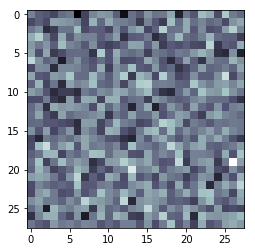

In [6]:
pl.imshow(np.squeeze(latent_sample784).reshape(28,28),
          cmap=pl.cm.bone); pl.show()

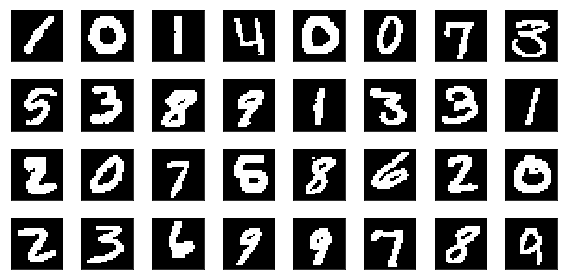

In [7]:
X_train_real=preprocess(train_images)
X_test_real =preprocess(test_images)
display_images(X_train_real[:32])

## ✒️ Keras GAN

In [8]:
def trainable(model,trainable):
    for layer in model.layers:
        layer.trainable=trainable
def simple_GAN(sample_size, 
               g_hidden_size, 
               d_hidden_size, 
               leaky_alpha, 
               g_learning_rate,
               d_learning_rate):    
    ks.backend.clear_session()    
    generator=Sequential([Dense(g_hidden_size,input_shape=(sample_size,)),
                          LeakyReLU(alpha=leaky_alpha),
                          Dense(784),Activation('tanh')], 
                         name='generator')    
    discriminator=Sequential([Dense(d_hidden_size,input_shape=(784,)),
                              LeakyReLU(alpha=leaky_alpha),
                              Dense(1),Activation('sigmoid')], 
                             name='discriminator')        
    gan=Sequential([generator,discriminator])    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), 
                          loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), 
                loss='binary_crossentropy')   
    return gan,generator,discriminator

In [9]:
sample_size     = 128     
g_hidden_size   = 784     # generator
d_hidden_size   = 128     # discriminator
leaky_alpha     = .02
g_learning_rate = .0001  # generator
d_learning_rate = .0005  # discriminator
epochs          = 200
batch_size      = 64      
valid_size      = 16     
smooth          = .1

In [10]:
def real_fake_labels(size):
    return np.ones([size,1]),np.zeros([size,1])
y_real5,y_fake5=real_fake_labels(5)
print('Real\n',list(y_real5),'\nFake\n',list(y_fake5))
y_train_real,y_train_fake=real_fake_labels(batch_size)
y_valid_real,y_valid_fake=real_fake_labels(valid_size)
gan,generator,discriminator=\
simple_GAN(sample_size,g_hidden_size,d_hidden_size,
           leaky_alpha,g_learning_rate,d_learning_rate)

Real
 [array([1.]), array([1.]), array([1.]), array([1.]), array([1.])] 
Fake
 [array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]


In [11]:
losses=[]
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real images
        X_batch_real=X_train_real[i*batch_size:(i+1)*batch_size]        
        # latent samples and generated letter images
        batch_latent_samples=latent_samples(batch_size,sample_size)
        X_batch_fake=generator.predict_on_batch(batch_latent_samples)        
        # train the discriminator to detect real and fake images
        trainable(discriminator,True)
        discriminator.train_on_batch(X_batch_real,y_train_real*(1.-smooth))
        discriminator.train_on_batch(X_batch_fake,y_train_fake)
        # train the generator via GAN
        trainable(discriminator,False)
        gan.train_on_batch(batch_latent_samples,y_train_real)    
    # evaluate
    X_valid_real=X_test_real[np.random.choice(len(X_test_real), 
                                              valid_size,replace=False)]    
    valid_latent_samples=latent_samples(valid_size,sample_size)
    X_valid_fake=generator.predict_on_batch(valid_latent_samples)
    d_loss=discriminator.test_on_batch(X_valid_real,y_valid_real)
    d_loss+=discriminator.test_on_batch(X_valid_fake,y_valid_fake)
    g_loss=gan.test_on_batch(valid_latent_samples,y_valid_real)     
    losses.append((d_loss,g_loss))
    st="Epoch: %d/%d | Discriminator Loss: %.4f | "+\
       "Generator Loss: %.4f | DL > GL: %s"
    if (e+1)%int(10)==0:
        print(st%((e+1,epochs,d_loss,g_loss,d_loss>g_loss)))
        if ((g_loss<.9) and (d_loss>g_loss)):
            latent_examples=latent_samples(32,sample_size)
            generated_digits=generator.predict(latent_examples)
            display_images(generated_digits)

Epoch: 10/200 | Discriminator Loss: 0.4306 | Generator Loss: 3.3274 | DL > GL: False
Epoch: 20/200 | Discriminator Loss: 0.3067 | Generator Loss: 2.2814 | DL > GL: False
Epoch: 30/200 | Discriminator Loss: 0.4101 | Generator Loss: 3.5976 | DL > GL: False
Epoch: 40/200 | Discriminator Loss: 0.7272 | Generator Loss: 2.2264 | DL > GL: False
Epoch: 50/200 | Discriminator Loss: 0.5973 | Generator Loss: 2.2695 | DL > GL: False
Epoch: 60/200 | Discriminator Loss: 0.8815 | Generator Loss: 2.1864 | DL > GL: False
Epoch: 70/200 | Discriminator Loss: 1.1620 | Generator Loss: 1.1423 | DL > GL: True
Epoch: 80/200 | Discriminator Loss: 1.1038 | Generator Loss: 2.0525 | DL > GL: False
Epoch: 90/200 | Discriminator Loss: 1.1855 | Generator Loss: 1.3623 | DL > GL: False
Epoch: 100/200 | Discriminator Loss: 1.0851 | Generator Loss: 1.1634 | DL > GL: False
Epoch: 110/200 | Discriminator Loss: 1.2543 | Generator Loss: 1.3157 | DL > GL: False
Epoch: 120/200 | Discriminator Loss: 1.0957 | Generator Loss: 1.

## ✒️ Display Results

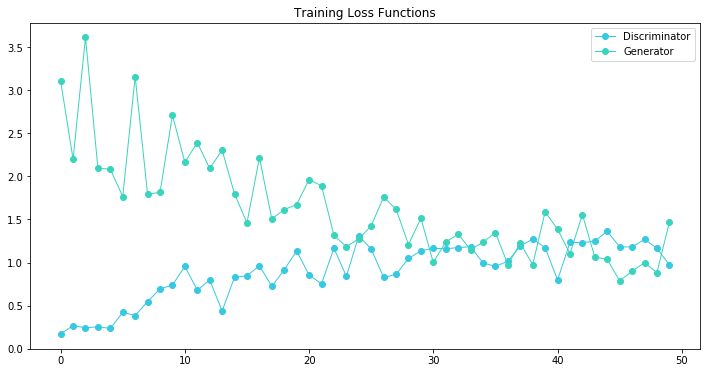

In [12]:
def display_loss(losses,n):
    indices=[i*n for i in range(len(losses)//n)]
    n_losses=np.array(losses)[indices,:]    
    pl.figure(figsize=(12,6))
    pl.plot(n_losses.T[0],'-o',c='#37c9e1',lw=1,
            label='Discriminator')
    pl.plot(n_losses.T[1],'-o',c='#39d4be',lw=1,
            label='Generator')
    pl.title("Training Loss Functions")
    pl.legend(); pl.show()
display_loss(losses,4)

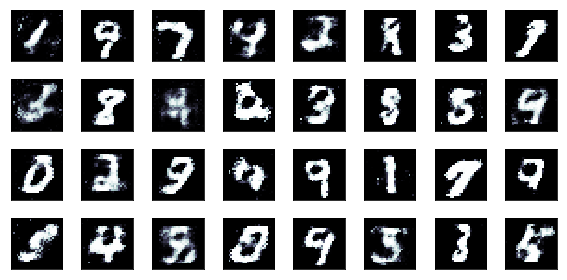

In [13]:
latent_examples=latent_samples(32,sample_size)
generated_digits=generator.predict(latent_examples)
display_images(generated_digits)